In [1]:
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from utils_reconstruction import image_similarity as imsim
import tifffile

In [2]:
## load reconstruction .npy files
num_neurons = [7863, 7908, 8202, 7939, 8122]
mouse_names = [
    "dynamic29515-10-12-Video-9b4f6a1a067fe51e15306b9628efea20",
    "dynamic29623-4-9-Video-9b4f6a1a067fe51e15306b9628efea20",
    "dynamic29647-19-8-Video-9b4f6a1a067fe51e15306b9628efea20",
    "dynamic29712-5-9-Video-9b4f6a1a067fe51e15306b9628efea20",
    "dynamic29755-2-8-Video-9b4f6a1a067fe51e15306b9628efea20",
]

max_num_neurons = np.max(num_neurons)
model_list = np.array([0,1,2,3,4,5,6]) # 1,2,3,4,5,6 # 0 held out!
mice = range(0,5) # max 5
trials = range(0,10)
trial_names = np.array([[0,1,2,10,4,5,6,7,8,11],
                        [10,1,2,3,11,5,6,7,8,9],
                        [10,1,14,3,4,5,6,15,16,9],
                        [0,1,2,3,10,5,6,7,8,9],
                        [0,1,2,3,4,5,6,7,8,9]])
pop_list = np.array([100,50,25,12])
eval_frame_skip = 30 # default is 30, 1 second (frame 31 is the first one with full information as the conv kernal is size 16 dilation 2)
mask_th = 1

video_gt=np.nan*np.ones((pop_list.size,len(mice),len(trials),300,36,64))
video_pred=np.nan*np.ones((pop_list.size,model_list.size,len(mice),len(trials),300,36,64))
mask=np.nan*np.ones((len(mice),36,64))

for model_n in range(0,len(model_list)):
    for mouse in mice:
        for trial in trials:
            for pop_n in range(0,pop_list.size):
                if pop_n==0:
                    datapath=f'../reconstructions/modelfold[{model_list[model_n]}]_datafold_0_pop{pop_list[pop_n]}_hpc_round5/reconstruction_summary_m{mouse}_t{trial_names[mouse,trial]}.npy'
                else:
                    datapath=f'../reconstructions/modelfold[{model_list[model_n]}]_datafold_0_pop{pop_list[pop_n]}_hpc_round4_popreduc/reconstruction_summary_m{mouse}_t{trial_names[mouse,trial]}.npy'
                print(datapath)
                data = np.load(datapath, allow_pickle=True).item()
                if model_list[model_n]==model_list[0]:
                    video_gt[pop_n,mouse,trial] = data['video_gt']

                video_pred[pop_n,model_n,mouse,trial] = data['video_pred']
                mask[mouse] = data['mask'][14:14+36,:]
            
# remove eval grace period
video_gt = video_gt[:,:,:,eval_frame_skip:,:,:]
video_pred = video_pred[:,:,:,:,eval_frame_skip:,:,:]

print('video_gt: ', video_gt.shape, video_gt.min(), video_gt.max())     
print('video_pred: ', video_pred.shape, video_pred.min(), video_pred.max())
print('mask: ', mask.shape, mask.min(), mask.max())

video_pred = np.clip(video_pred, 0, 255) 


../reconstructions/modelfold[0]_datafold_0_pop100_hpc_round5/reconstruction_summary_m0_t0.npy
../reconstructions/modelfold[0]_datafold_0_pop50_hpc_round4_popreduc/reconstruction_summary_m0_t0.npy
../reconstructions/modelfold[0]_datafold_0_pop25_hpc_round4_popreduc/reconstruction_summary_m0_t0.npy
../reconstructions/modelfold[0]_datafold_0_pop12_hpc_round4_popreduc/reconstruction_summary_m0_t0.npy
../reconstructions/modelfold[0]_datafold_0_pop100_hpc_round5/reconstruction_summary_m0_t1.npy
../reconstructions/modelfold[0]_datafold_0_pop50_hpc_round4_popreduc/reconstruction_summary_m0_t1.npy
../reconstructions/modelfold[0]_datafold_0_pop25_hpc_round4_popreduc/reconstruction_summary_m0_t1.npy
../reconstructions/modelfold[0]_datafold_0_pop12_hpc_round4_popreduc/reconstruction_summary_m0_t1.npy
../reconstructions/modelfold[0]_datafold_0_pop100_hpc_round5/reconstruction_summary_m0_t2.npy
../reconstructions/modelfold[0]_datafold_0_pop50_hpc_round4_popreduc/reconstruction_summary_m0_t2.npy
../r

In [3]:
# arithmetic mean of all models
video_pred_Amean_all = np.nanmean(video_pred, axis=1)

# gaussian filtered version of arithmetic mean of all models
video_pred_Amean_all_gauss = np.zeros(video_pred_Amean_all.shape)
for pop_n in range(0,pop_list.size):
    for mouse in range(video_pred_Amean_all.shape[1]):
        for trial in range(video_pred_Amean_all.shape[2]):
            video_pred_Amean_all_gauss[pop_n,mouse,trial] = sp.ndimage.gaussian_filter(video_pred_Amean_all[pop_n,mouse,trial], sigma=(0.5, 0.5, 0.5))
video_pred_Amean_all = video_pred_Amean_all_gauss

# plotting

In [6]:
# distribution of correlation values for full model

for pop_n in range(0,pop_list.size):
        vid_corr_values = np.zeros((len(mice),len(trials)))
        frame_corr_values = np.zeros((len(mice),len(trials)))
        
        for mouse in mice:
                for trial in trials:
                        vid_corr_values[mouse,trial]=imsim.reconstruction_video_corr(video_gt[pop_n,mouse,trial],
                                video_pred_Amean_all[pop_n,mouse,trial],
                                np.where(mask[mouse] >= mask_th,1,0))
                        frame_corr_values[mouse,trial]=imsim.reconstruction_video_mean_frame_corr(video_gt[pop_n,mouse,trial],
                                video_pred_Amean_all[pop_n,mouse,trial],
                                np.where(mask[mouse] >= mask_th,1,0))
                
        if pop_n==0:
                vid_corr_values_100 = vid_corr_values.mean(1)
                frame_corr_values_100 = frame_corr_values.mean(1)
        elif pop_n==1:
                vid_corr_values_50 = vid_corr_values.mean(1)
                frame_corr_values_50 = frame_corr_values.mean(1)
        elif pop_n==2:
                vid_corr_values_25 = vid_corr_values.mean(1)
                frame_corr_values_25 = frame_corr_values.mean(1)
        elif pop_n==3:
                vid_corr_values_12 = vid_corr_values.mean(1)
                frame_corr_values_12 = frame_corr_values.mean(1)

/ceph/margrie/joelb/video_reconstruction_from_sensorium2023_winner/venv3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/ceph/margrie/joelb/video_reconstruction_from_sensorium2023_winner/venv3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [7]:
## do repeated measures anova

# Transpose to get samples for each group
data = np.concatenate((vid_corr_values_12[:,None],
                vid_corr_values_25[:,None],
                vid_corr_values_50[:,None],
                vid_corr_values_100[:,None]),axis=1)

# Number of groups and subjects
n_subjects, n_groups = data.shape

# Grand mean
grand_mean = np.mean(data)

# Mean of each subject
subject_means = np.mean(data, axis=1)

# Mean of each group
group_means = np.mean(data, axis=0)

# Total sum of squares (SST)
SST = np.sum((data - grand_mean) ** 2)

# Sum of squares between groups (SSB)
SSB = n_subjects * np.sum((group_means - grand_mean) ** 2)

# Sum of squares between subjects (SSW)
SSW = n_groups * np.sum((subject_means - grand_mean) ** 2)

# Sum of squares error (SSE)
SSE = SST - SSB - SSW

# Degrees of freedom
df_between = n_groups - 1
df_within = n_subjects - 1
df_error = df_between * df_within

# Mean squares
MS_between = SSB / df_between
MS_error = SSE / df_error

# F-statistic
F = MS_between / MS_error

# P-value
p_value = 1 - sp.stats.f.cdf(F, df_between, df_error)

print(f'number of groups: {n_groups}')
print(f'number of subjects: {n_subjects}')
print(f'F-statistic: {F}')
print(f'p-value: {p_value}')

# Post-hoc test: Pairwise t-tests with Bonferroni correction
pairwise_comparisons = []
alpha = 0.05
num_comparisons = n_groups - 1 
corrected_alpha = alpha / num_comparisons

for i in range(n_groups-1):
    t_stat, p_val = sp.stats.ttest_rel(data[:, i], data[:, i+1])
    pairwise_comparisons.append((i, i+1, t_stat, p_val, p_val < corrected_alpha))

print("\nPairwise Comparisons (with Bonferroni correction):")
print("Group1, Group2, t-statistic, p-value, Significant")
for comp in pairwise_comparisons:
    print(comp)


number of groups: 4
number of subjects: 5
F-statistic: 521.2395858228449
p-value: 5.702105454474804e-13

Pairwise Comparisons (with Bonferroni correction):
Group1, Group2, t-statistic, p-value, Significant
(0, 1, -13.397609245267295, 0.00017950710376077924, True)
(1, 2, -19.14221845764335, 4.388556902907587e-05, True)
(2, 3, -19.48457069429771, 4.0907210649182023e-05, True)


vid corr for 12.5,25,50,100:  [0.3443467253742075, 0.4273313454266915, 0.512074088586291, 0.5687160439598534]
vid corr percentate decrease from 100 to 50,  50 to 25 and 25 to 12.5:  [-9.959619739083859, -24.860332328367107, -39.45190591484078]
vid corr percentate decrease from 100 to 12.5:  -39.45190591484078


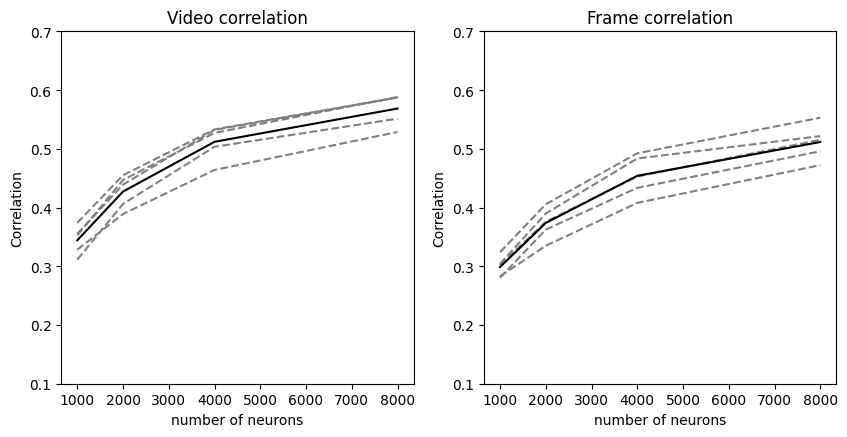

In [11]:
# line plot with std error bars
vid_corr_values_100_mean = np.mean(vid_corr_values_100)
vid_corr_values_100_std = np.std(vid_corr_values_100)
frame_corr_values_100_mean = np.mean(frame_corr_values_100)
frame_corr_values_100_std = np.std(frame_corr_values_100)

vid_corr_values_50_mean = np.mean(vid_corr_values_50)
vid_corr_values_50_std = np.std(vid_corr_values_50)
frame_corr_values_50_mean = np.mean(frame_corr_values_50)
frame_corr_values_50_std = np.std(frame_corr_values_50)

vid_corr_values_25_mean = np.mean(vid_corr_values_25)
vid_corr_values_25_std = np.std(vid_corr_values_25)
frame_corr_values_25_mean = np.mean(frame_corr_values_25)
frame_corr_values_25_std = np.std(frame_corr_values_25)

vid_corr_values_12_mean = np.mean(vid_corr_values_12)
vid_corr_values_12_std = np.std(vid_corr_values_12)
frame_corr_values_12_mean = np.mean(frame_corr_values_12)
frame_corr_values_12_std = np.std(frame_corr_values_12)



# plot 
fig, ax = plt.subplots(1,2, figsize=(10,5))
for mouse in mice:
    ax[0].plot([1000, 2000,4000,8000], [vid_corr_values_12[mouse],vid_corr_values_25[mouse],vid_corr_values_50[mouse], vid_corr_values_100[mouse]], '--', color='gray')
ax[0].plot([1000, 2000,4000,8000], [vid_corr_values_12_mean,vid_corr_values_25_mean,vid_corr_values_50_mean, vid_corr_values_100_mean], 'k')
ax[0].set_title('Video correlation')
ax[0].set_xlabel('number of neurons')
ax[0].set_ylabel('Correlation')
ax[0].set_ylim([0.1,0.7])
ax[0].set_box_aspect(1)
# add trend line

for mouse in mice:
    ax[1].plot([1000, 2000,4000,8000], [frame_corr_values_12[mouse],frame_corr_values_25[mouse],frame_corr_values_50[mouse], frame_corr_values_100[mouse]], '--', color='gray')
ax[1].plot([1000, 2000,4000,8000], [frame_corr_values_12_mean,frame_corr_values_25_mean,frame_corr_values_50_mean, frame_corr_values_100_mean], 'k')
ax[1].set_title('Frame correlation')
ax[1].set_xlabel('number of neurons')
ax[1].set_ylabel('Correlation')
ax[1].set_ylim([0.1,0.7])
ax[1].set_box_aspect(1)

# save plot as svg
fig.savefig('../reconstructions/population_ablation.svg', format='svg', dpi=1200)
print('vid corr for 12.5,25,50,100: ', [vid_corr_values_12_mean,vid_corr_values_25_mean,vid_corr_values_50_mean, vid_corr_values_100_mean])
percentage_improvements = [(vid_corr_values_50_mean/vid_corr_values_100_mean-1)*100,(vid_corr_values_25_mean/vid_corr_values_100_mean-1)*100,(vid_corr_values_12_mean/vid_corr_values_100_mean-1)*100]
print('vid corr percentate decrease from 100 to 50,  100 to 25 and 100 to 12.5: ', percentage_improvements)
print('vid corr percentate decrease from 100 to 12.5: ', (vid_corr_values_12_mean/vid_corr_values_100_mean-1)*100)

In [9]:
# contrast adjust images
def contrast_match_videos(y,gt,mask,mask_th):
    frame_n = gt.shape[-3]
    h_n = gt.shape[-2]
    w_n = gt.shape[-1]
    
    gt_mean = np.nanmean(gt, axis=-3)
    gt_mean = gt_mean * np.where(mask >= mask_th,1,np.nan) 
    target_means = np.nanmean(gt_mean, axis=(-1,-2))
    target_stds = np.nanstd(gt_mean, axis=(-1,-2))
    
    y_mean = np.nanmean(y, axis=-3)
    y_mean = y_mean * np.where(mask >= mask_th,1,np.nan)
    start_means = np.nanmean(y_mean, axis=(-1,-2))
    start_stds = np.nanstd(y_mean, axis=(-1,-2))
    
    y_zscore = (y - start_means)  / start_stds
    y_norm = (y_zscore*target_stds) + target_means
    y_norm = np.clip(y_norm, 0, 255)
        
    # reaply mask
    mask_expanded = np.expand_dims(mask,axis=(0)).repeat(frame_n,axis=0)
    gt_masked = gt * np.where(mask_expanded >= mask_th,1,np.nan) 
    y_masked = y_norm * np.where(mask_expanded >= mask_th,1,np.nan) 
    y_norm_masked = y_norm * np.where(mask_expanded >= mask_th,1,np.nan)

    gt_masked[np.isnan(gt_masked)] = 255/2
    y_masked[np.isnan(y_masked)] = 255/2
    y_norm_masked[np.isnan(y_norm_masked)] = 255/2

    return y_norm_masked, gt_masked

(4, 270, 23, 28)


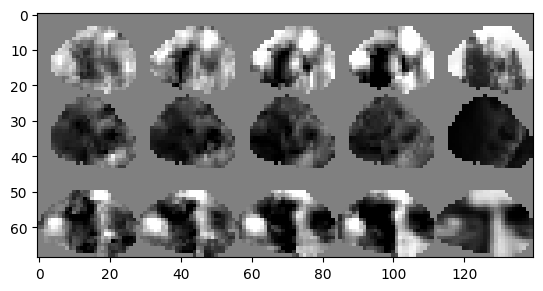

In [10]:
f,h,w= video_gt.shape[-3],video_gt.shape[-2],video_gt.shape[-1]

recon_1 = video_pred_Amean_all[:,0,6]
recon_2 = video_pred_Amean_all[:,3,3]
recon_3 = video_pred_Amean_all[:,4,2]

gt_1 = video_gt[0,0,6]
gt_2 = video_gt[0,3,3]
gt_3 = video_gt[0,4,2]

for i in range(4):
    recon_1[i], gt_1 = contrast_match_videos(recon_1[i],gt_1,mask[0],mask_th)
    recon_2[i], gt_2 = contrast_match_videos(recon_2[i],gt_2,mask[3],mask_th)
    recon_3[i], gt_3 = contrast_match_videos(recon_3[i],gt_3,mask[4],mask_th)
    
mask_all = np.where(np.sum(np.where(mask >= mask_th,1,0),axis=0) >= 1,1,0)
mask_all_idx = np.where(mask_all == 1)
h_min, h_max = np.min(mask_all_idx[0]), np.max(mask_all_idx[0])
w_min, w_max = np.min(mask_all_idx[1]), np.max(mask_all_idx[1])
h = h_max - h_min
w = w_max - w_min
recon_1 = recon_1[:,:,h_min:h_max,w_min:w_max]
recon_2 = recon_2[:,:,h_min:h_max,w_min:w_max]
recon_3 = recon_3[:,:,h_min:h_max,w_min:w_max]
gt_1 = gt_1[:,h_min:h_max,w_min:w_max]
gt_2 = gt_2[:,h_min:h_max,w_min:w_max]
gt_3 = gt_3[:,h_min:h_max,w_min:w_max]

print(recon_1.shape)

recon_1 = np.moveaxis(np.moveaxis(np.flip(recon_1,axis=0), -1, 1).reshape((len(pop_list)*w,f, h)), 0, -1)
recon_2 = np.moveaxis(np.moveaxis(np.flip(recon_2,axis=0), -1, 1).reshape((len(pop_list)*w,f, h)), 0, -1)
recon_3 = np.moveaxis(np.moveaxis(np.flip(recon_3,axis=0), -1, 1).reshape((len(pop_list)*w,f, h)), 0, -1)

recon_1 = np.concatenate([recon_1, gt_1], axis=-1)
recon_2 = np.concatenate([recon_2, gt_2], axis=-1)
recon_3 = np.concatenate([recon_3, gt_3], axis=-1)

recon_all = np.concatenate([recon_1, recon_2, recon_3], axis=-2)

plt.imshow(recon_all[50], cmap='gray', vmin=0, vmax=255)

# save original videos
tifffile.imwrite('../reconstructions/population_ablation_examples.tiff', 
               recon_all.astype('uint8'),
                imagej=True,
                metadata = {'unit': 'um','fps': 30.0,'axes': 'TYX',})
